In [1]:
# Import pandas library
import pandas as pd

# Load the data, separate features from target
data = pd.read_csv("./synthetic_credit_card_approval.csv")

# Preview the data
print("Data successfully loaded!\n")
data.head(10)

FileNotFoundError: [Errno 2] No such file or directory: './synthetic_credit_card_approval.csv'

## Exercise (idea)

Explore data visualisations and see if we can see any early signs of bias or unfairness in this data

Next, we will organise these data into features `X` and a target variable `y`, and randomly split the data into a training set used to train the model and a testing set used to evaluate it.

We use 80% of the data for training, and 20% for testing.

In [2]:
from sklearn.model_selection import train_test_split

X = data.drop(["Target"], axis=1)
y = data["Target"]

# Break into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

The next code cell will train a simple model to approve or deny individuals for a credit card.  The output shows the performance of the model.

Total approvals: 38246
Group A: 8028 (20.99% of approvals)
Group B: 30218 (79.01% of approvals)

Overall accuracy: 94.79%
Group A: 94.56%
Group B: 95.02%

Overall sensitivity / True positive rate: 92.78%
Group A: 77.23%
Group B: 98.03%


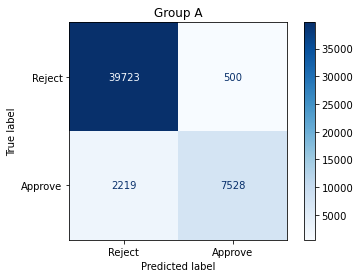

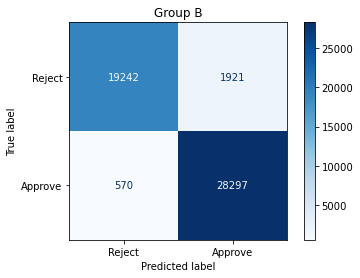

In [3]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train a model and make predictions
model_baseline = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_baseline.fit(X_train, y_train)
preds_baseline = model_baseline.predict(X_test)


# Function to plot confusion matrix
def plot_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Reject", "Approve"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    return cm, disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)

# Function to evaluate the fairness of the model
def get_stats(X, y, model, group_one, preds):
        
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    print("Total approvals:", preds.sum())
    print("Group A:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
    print("Group B:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))
    
    print(f"\nOverall accuracy: {round((preds==y).sum()/len(y)*100, 2)}%")
    print("Group A: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group B: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))
    
    cm_zero, disp_zero = plot_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group A")
    cm_one, disp_one = plot_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group B")
    
    print(f"\nOverall sensitivity / True positive rate: {round((cm_zero[1,1]+cm_one[1,1]) / (cm_zero[1].sum()+cm_one[1].sum())*100, 2)}%")
    print("Group A: {}%".format(round(cm_zero[1,1] / cm_zero[1].sum()*100, 2)))
    print("Group B: {}%".format(round(cm_one[1,1] / cm_one[1].sum()*100, 2)))
    
# Evaluate the model    
get_stats(X_test, y_test, model_baseline, X_test["Group"]==1, preds_baseline)

The confusion matrices tell us how the model performs on the test data. We've also printed some additional information (which can be calculated from the confusion matrices) to assess fairness of the model.
We can see that
- The model approved 38246 people for a credit card. Of these individuals, 8028 belonged to Group A, and 30218 belonged to Group B.
- The model is 94.56% accurate for Group A, and 95.02% accurate for Group B. These percentages can be calculated directly from the confusion matrix via (True positives + True negatives) / (Total applicants).
- The true positive rate (TPR) for Group A is 77.23%, and the TPR for Group B is 98.03%. Again, these percentages can be calculated from the confusion matrix, this time via (True positives)/(True positives + False positives).

# 1) Varieties of fairness

Let us consider the three different types of fairness we discussed in the guided practice:
- **Demographic parity**: We know that roughly 50% of applicants are from group A and 50% of applicants are from group B. Which group (if any) has more representation in the group of approved applicants?
- **Equal accuracy**: Which group is more likely to be correctly classified?
- **Equal opportunity**:  Which group (if any) is more likely to be correctly approved?

You may write notes here:


Run the next code cell without changes to visualize the model.

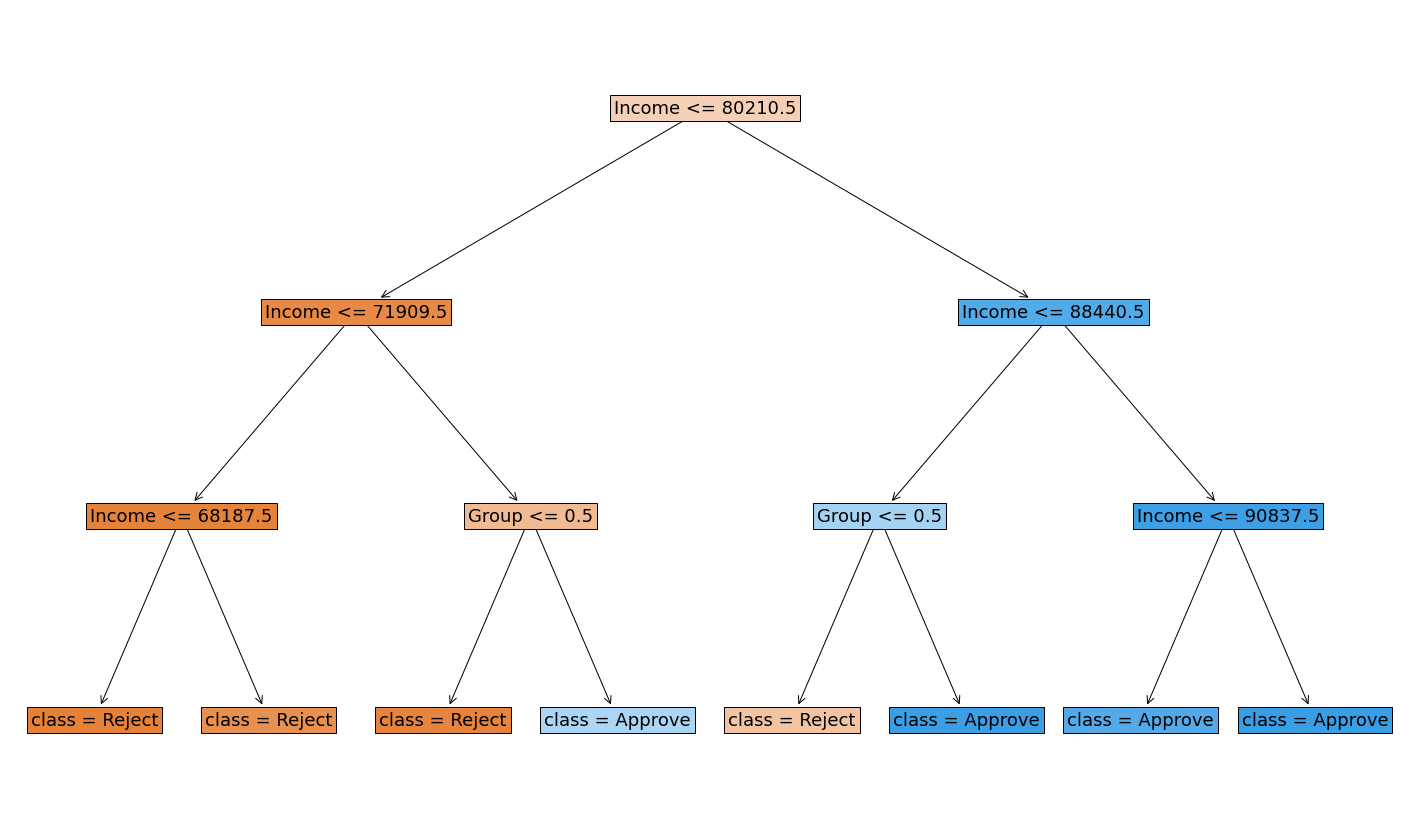

In [4]:
def visualize_model(model, feature_names, class_names):
    plot_list = tree.plot_tree(model, 
                               feature_names=feature_names, 
                               class_names=class_names, 
                               impurity=False, 
                               filled=True,
                               fontsize=18)
    [format_item(item) for item in plot_list]

def format_item(item):
    split_string = item.get_text().split("\n")
    if split_string[0].startswith("samples") or split_string[0].startswith("values"):
        item.set_text(split_string[-1])
    else:
        item.set_text(split_string[0])

plt.figure(figsize=(25, 15))
plot_list = visualize_model(model=model_baseline, feature_names=X_train.columns, class_names=["Reject", "Approve"])

The flowchart shows how the model makes decisions:
- `Group <= 0.5` checks what group the applicant belongs to: if the applicant belongs to Group A, then `Group <= 0.5` is true.
- Entries like `Income <= X` check whether the applicant's income is less than or equal to X

We can use this model 'manually' by choosing a row from our data. Starting at the top, we trace a path depending on the details of the applicant.  If the condition is true at a split, then we move down the left branch.  If it's false, then we move down the right branch until we arrive at the bottom of the tree that gives us the result 'Approve' or 'Reject'.

e.g., consider a Group B applicant with an income of 75k.  Then starting from the top
- The applicant has an income of 75k, so `Income <= 80210.5` is true, and we move down to left branch.
- Next, we check income again. Since `Income <= 71909.5` is false, we move to down the right branch.
- Finally, we check what group the applicant belings to.  The applicant belongs to Group B, so `Group <= 0.5` is false, and we move down to the right, where the model outputs that we should approve the applicant.

# 2) Understand the baseline model

Based on the visualization, can we see any unfairness in the model?

**Hint**: Consider the example applicant, but change the group membership from Group B to Group A (leaving all other characteristics the same).  Is this slightly different applicant approved or denied by the model?

write notes here:


Next, we decide to remove group membership from the training data and train a new model.  Will this make the model treat the groups more equally?

Run the next code cell to see how this **unaware** model performs.

Total approvals: 36670
Group A: 11624 (31.7% of approvals)
Group B: 25046 (68.3% of approvals)

Overall accuracy: 92.66%
Group A: 93.61%
Group B: 91.72%

Overall sensitivity / True positive rate: 87.98%
Group A: 93.24%
Group B: 86.21%


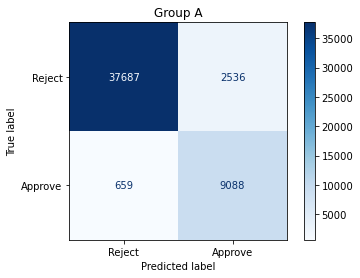

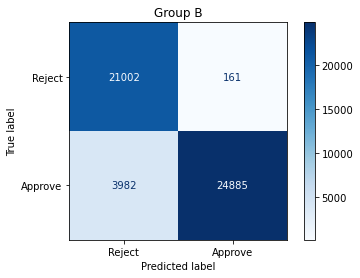

In [5]:
# Create new dataset with gender removed
X_train_unaware = X_train.drop(["Group"],axis=1)
X_test_unaware = X_test.drop(["Group"],axis=1)

# Train new model on new dataset
model_unaware = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_unaware.fit(X_train_unaware, y_train)

# Evaluate the model
preds_unaware = model_unaware.predict(X_test_unaware)
get_stats(X_test_unaware, y_test, model_unaware, X_test["Group"]==1, preds_unaware)

# 3) Varieties of fairness, part 2

How does this model compare to the first model you trained, when you consider **demographic parity**, **equal accuracy**, and **equal opportunity**?  Write your observations in the next cell.

Let's train another model, this time with the goal of achieving equal representation of Group A and Group B in the group of approved applicants. We then 

Run the next code cell without changes to evaluate the new model, then alter the `zero_threshold` value and run it again until you are satisfied. What do you notice? Note: while you change the threshold to alter the representation amongst approved applicants, take notes of how the other metrics, accuracy and sensitivity change.

Total approvals: 40774
Group A: 19869 (48.73% of approvals)
Group B: 20905 (51.27% of approvals)

Overall accuracy: 81.92%
Group A: 79.74%
Group B: 84.09%

Overall sensitivity / True positive rate: 79.38%
Group A: 100.0%
Group B: 72.42%


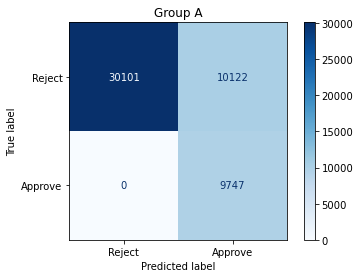

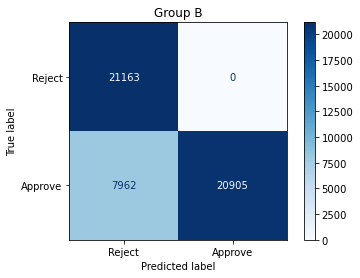

In [7]:
# Change the value of zero_threshold to hit the objective
A_threshold = 0.11
B_threshold = 1-A_threshold

# Evaluate the model
test_probs = model_unaware.predict_proba(X_test_unaware)[:,1]
preds_approval = (((test_probs>A_threshold)*1)*[X_test["Group"]==0] + ((test_probs>B_threshold)*1)*[X_test["Group"]==1])[0]
get_stats(X_test, y_test, model_unaware, X_test["Group"]==1, preds_approval)

# 4) Varieties of fairness, part 3

How does this final model compare to the previous models, when you consider **demographic parity**, **equal accuracy**, and **equal opportunity**?

This is only a short exercise to explore different types of fairness, and to illustrate the tradeoff that can occur when we optimize for one type of fairness over another.  We've focused on model training here, although in practice, bias mitigation is a much deeper process that requires careful thought at every step of the process from data collection, model selection, training and optimisation, right through to evalutating outputs and engaging with stakeholder groups to both communicate on what the model does, how it works and its failure points. 

In this case, if we take a close look at the data, we notice that on average, individuals from Group B tend to have higher income than individuals from Group A, as well as being more likely to own a home or a car. Identifying biases like these, as well as consideration of the use case is crucial to determining what fairness metrics to consider. (*For instance, if we don't address extant biases in the data and then train a model to produce equal accuracy for each group, we will likely only end up reproducing the biases in the model outputs.*)

